In [1]:

# ================== Install Dependencies ==================
!pip install -q faiss-cpu sentence-transformers bitsandbytes accelerate transformers peft datasets pandas scikit-learn matplotlib
!pip install -q torch keras

# ================== Imports ==================
import pandas as pd
import numpy as np
import faiss, torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.3 MB/s eta 0:00:00


In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
# ========== Log Dictionary for Charts ==========
logs = {
    "preprocessing": {},
    "data_split": {},
    "training_metrics": {
        "epoch_loss": [],
        "epoch_mae": [],
        "val_loss": [],
        "val_mae": []
    },
    "recommendations": []
}

# ================== Load Dataset ==================
url = "https://huggingface.co/datasets/panda04/smart-home-dataset/raw/main/smart_home_dataset.csv"
data = pd.read_csv(url)

In [3]:

# ========== Preprocessing ==========

def preprocess_data(df):
    df = df.drop(['Transaction_ID', 'Unix Timestamp'], axis=1)

    # Time-based features
    df['is_peak_hour'] = df['Hour of the Day'].apply(lambda x: 1 if (6 <= x <= 9) or (18 <= x <= 21) else 0)
    df['part_of_day'] = pd.cut(df['Hour of the Day'], bins=[0, 6, 12, 18, 24],
                               labels=['night', 'morning', 'afternoon', 'evening'], right=False)
    df['is_weekend'] = df['Day of the Week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

    # Season
    season_dict = {12:'winter', 1:'winter', 2:'winter', 3:'spring', 4:'spring', 5:'spring',
                   6:'summer', 7:'summer', 8:'summer', 9:'fall', 10:'fall', 11:'fall'}
    df['Season'] = df['Month'].map(season_dict)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)

    # Appliance Features
    appliances = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    df['total_appliance_usage'] = df[appliances].sum(axis=1)

    # High Consumption Label
    threshold = df['Energy Consumption (kWh)'].quantile(0.75)
    df['is_high_consumption'] = df['Energy Consumption (kWh)'].apply(lambda x: 1 if x > threshold else 0)

    # Normalize
    features_to_scale = ['Line Voltage', 'Voltage', 'Apparent Power', 'Energy Consumption (kWh)']
    df[features_to_scale] = MinMaxScaler().fit_transform(df[features_to_scale])

    # Appliance efficiency & power factor
    for a in appliances:
        df[f'{a}_efficiency_ratio'] = df[a] / (df['Energy Consumption (kWh)'] + 1e-6)
    df['power_factor'] = df['Apparent Power'] / (df['Line Voltage'] * df['Voltage'] + 1e-6)

    # Active appliances
    df['active_appliances'] = df[appliances].gt(0).sum(axis=1)
    df['energy_per_active_appliance'] = df['Energy Consumption (kWh)'] / (df['active_appliances'] + 1e-6)

    # === Add these log updates here ===
    logs['preprocessing']['total_rows'] = len(df)
    logs['preprocessing']['high_consumption_threshold'] = threshold
    logs['preprocessing']['appliances'] = appliances

    return df

# === Apply Preprocessing ===
data = preprocess_data(data)

In [4]:
# ========== Prepare LSTM Data ==========
def prepare_lstm_data(df):
    df = df.copy()

    # Drop unneeded columns
    if 'text_description' in df.columns:
        df = df.drop(['text_description'], axis=1)

    # One-hot encode categorical variables
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Separate features and labels
    X = df.drop('is_high_consumption', axis=1)
    y = df['is_high_consumption']

    return train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.4, random_state=42)

# === Split dataset ===
X_train, X_temp, y_train, y_temp = prepare_lstm_data(data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Log split sizes
logs['data_split']['X_train'] = len(X_train)
logs['data_split']['X_val'] = len(X_val)
logs['data_split']['X_test'] = len(X_test)

# ========== LSTM Model ==========

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def create_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=False, unroll=True),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def create_sequences(X, y, time_steps=24):
    return np.array([X[i:i+time_steps] for i in range(len(X)-time_steps)]), \
           np.array([y[i+time_steps] for i in range(len(y)-time_steps)])

# Sequence creation and training
with tf.device('/CPU:0'):
    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values)
    X_val_seq, y_val_seq = create_sequences(X_val.values, y_val.values)

    lstm_model = create_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))

    for epoch in range(10):
        history = lstm_model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=1, batch_size=32, verbose=0
        )
        logs["training_metrics"]["epoch_loss"].append(history.history['loss'][0])
        logs["training_metrics"]["epoch_mae"].append(history.history['mae'][0])
        logs["training_metrics"]["val_loss"].append(history.history['val_loss'][0])
        logs["training_metrics"]["val_mae"].append(history.history['val_mae'][0])

In [5]:
# ========== Text Descriptions & Embeddings ==========
def generate_text_description(row):
    a = ['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']
    status = ", ".join(f"{x}: {'ON' if row[x] > 0 else 'OFF'}" for x in a)
    return f"At {int(row['Hour of the Day'])}:00 during {row['Season']} {row['part_of_day']}, appliances: {status}. Energy: {row['Energy Consumption (kWh)']:.2f}kWh"

from sentence_transformers import SentenceTransformer
import faiss

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate and normalize embeddings
data['text_description'] = data.apply(generate_text_description, axis=1)
embeddings = embedding_model.encode(data['text_description'].tolist(), show_progress_bar=True, normalize_embeddings=True)

# FAISS index (L2 works better with normalized vectors)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1531 [00:00<?, ?it/s]

In [6]:
import torch
torch.cuda.empty_cache()


In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

import torch
torch.cuda.empty_cache()

model_id = "deepseek-ai/deepseek-llm-7b-chat"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

# Apply LoRA PEFT wrapper
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    inference_mode=True,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

model = get_peft_model(base_model, lora_config)
model.eval()


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(102400, 4096)
        (layers): ModuleList(
          (0-29): 30 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import seaborn as sns

# Initialize or preserve existing gr_log
if 'gr_log' not in globals():
    gr_log = {}

gr_log.setdefault("recommendations", [])
gr_log.setdefault("lengths", [])
gr_log.setdefault("timestamps", [])
gr_log.setdefault("categories", [])


from datetime import datetime

def generate_recommendations(model, tokenizer, user_logs, forecast_data, context_data, max_tokens=1024):
    prompt = f"""
### Instruction:
Use the context, user log, and forecast to suggest actionable energy optimization recommendations for the user.
Make sure the suggestions are practical and categorized into: Usage Tips, Scheduling Suggestions, and Device Recommendations.

### Context:
{context_data}

### User Log:
{user_logs}

### Forecasted Energy Usage:
{forecast_data} kWh

### Response:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=len(inputs['input_ids'][0]) + max_tokens,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.2,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    recommendation = response.split("### Response:")[-1].strip()

    gr_log["recommendations"].append({
    "user_log": user_logs,
    "forecast": forecast_data,
    "context": context_data,
    "output": recommendation
    })
    logs['recommendations'].append({
        "user_log": user_logs,
        "forecast": forecast_data,
        "context": context_data,
        "output": recommendation
    })
    gr_log["lengths"].append(len(recommendation))
    gr_log["timestamps"].append(datetime.now().isoformat())
    gr_log["categories"].append({
        "Usage Tips": recommendation.lower().count("usage tip"),
        "Scheduling Suggestions": recommendation.lower().count("scheduling suggestion"),
        "Device Recommendations": recommendation.lower().count("device recommendation")
    })


    return recommendation


In [9]:
# ========== Run Recommendation Example ==========
user_logs = "The user is using AC and Fan together for 14 hours."
forecast_data = "2.85"
context_data = """
At 20:00 during summer evening, appliances: Television: OFF, Dryer: OFF, Oven: OFF, Refrigerator: ON, Microwave: ON. Energy: 0.60kWh
At 21:00 during summer evening, appliances: Television: ON, Dryer: OFF, Oven: ON, Refrigerator: ON, Microwave: OFF. Energy: 0.96kWh
"""
recommendation = generate_recommendations(model, tokenizer, user_logs, forecast_data, context_data)
print(recommendation)

Usage tips - Turn off unused devices like television or microwave when not in use; minimize usage of air conditioner by keeping room temperature slightly higher than usual (e.g., around 78°F/26°C); consider investing in a smart thermostat that can learn your preferences & optimize settings automatically based on time-of-day scheduling options available within its programming capabilities allowing you better control over how much power these systems consume without sacrificing comfort levels at home!


In [10]:
user_logs = "The user is using Dryer and Refrigerator together."
forecast_data = "2.86"
context_data = """
At 20:00 during summer evening, appliances: Television: OFF, Dryer: ON, Oven: OFF, Refrigerator: ON, Microwave: ON. Energy: 0.90kWh
At 21:00 during summer evening, appliances: Television: ON, Dryer: ON, Oven: ON, Refrigerator: ON, Microwave: ON. Energy: 1.96kWh
"""

recommendation = generate_recommendations(model, tokenizer, user_logs, forecast_data, context_data)
print(recommendation)


Usage Tips: Try to reduce your appliance usage by turning off TVs when not in use or reducing their brightness levels as much as possible; also consider switching to LED bulbs which consume less electricity than traditional incandescent ones while providing similar lighting quality! Additionally, try scheduling certain tasks like laundry at times of lower consumption (e.g., overnight) if you can't avoid them altogether - this will help save money on bills over time too since peak hours tend cost more per unit generated due high demand from other customers around town who might be running various home equipment simultaneously creating an imbalance within our grid system causing higher costs overall experienced ultimately passed onto consumers via increased monthly charges imposed upon us all collectively speaking here today...


In [11]:
user_logs = "The user is using Oven and Refrigerator together."
forecast_data = "1.93"
context_data = """
At 10:00 during summer Morning, appliances: Television: OFF, Dryer: OFF, Oven: ON, Refrigerator: ON, Microwave: ON. Energy: 0.94kWh
At 23:00 during summer Night, appliances: Television: ON, Dryer: OFF, Oven: ON, Refrigerator: ON, Microwave: ON. Energy: 0.99kWh
"""

recommendation = generate_recommendations(model, tokenizer, user_logs, forecast_data, context_data)
print(recommendation)


Usage Tips: To save on your electricity bill, consider turning off devices when they're not in use or unplugging them from power outlets completely. In this case, you could turn off the television at nighttime since it’s an additional load that isn't necessary then but will still consume some amount of energy even if turned down low (e.g., standby mode). Additionally, try adjusting thermostat settings throughout different times within a day so as to minimize overall usage while keeping comfort levels acceptable! Lastly remember scheduling tasks like laundry can be done earlier mornings rather than late nights which would contribute significantly towards lowering one's monthly electric bills by reducing peak-demand charges incurred due increased consumption rates overnight hours specifically among residential customers who experience high demand periods between midnight & sunrise...


In [12]:
!pip install matplotlib scikit-learn seaborn


In [13]:
%matplotlib inline


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

# 1. Training and Validation Loss Curves
def plot_loss_curves(logs):
    epochs = range(1, len(logs['training_metrics']['epoch_loss']) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, logs['training_metrics']['epoch_loss'], label='Training Loss')
    plt.plot(epochs, logs['training_metrics']['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Training and Validation Accuracy Curves (using MAE here as proxy)
def plot_accuracy_curves(logs):
    epochs = range(1, len(logs['training_metrics']['epoch_mae']) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, logs['training_metrics']['epoch_mae'], label='Training MAE')
    plt.plot(epochs, logs['training_metrics']['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE (Lower is better)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Helper to extract true labels and scores from logs['recommendations']
def extract_labels_scores(logs):
    y_true = []
    y_scores = []
    for rec in logs['recommendations']:
        try:
            clicked = rec['user_log'].get('clicked', None)
            score = rec['output'].get('score', None)
            if clicked is not None and score is not None:
                y_true.append(clicked)
                y_scores.append(score)
        except Exception as e:
            # skip malformed entries
            continue
    return np.array(y_true), np.array(y_scores)

# 3. Precision-Recall Curve
def plot_precision_recall_curve(logs):
    y_true, y_scores = extract_labels_scores(logs)
    if len(y_true) == 0:
        print("No valid recommendation labels/scores for PR curve.")
        return
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    plt.figure(figsize=(8,6))
    plt.step(recall, precision, where='post', color='b')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve (AP={ap:.3f})')
    plt.grid(True)
    plt.show()

# 4. ROC Curve
def plot_roc_curve(logs):
    y_true, y_scores = extract_labels_scores(logs)
    if len(y_true) == 0:
        print("No valid recommendation labels/scores for ROC curve.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC={auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Mean Average Precision (MAP) over epochs - Dummy example if you keep MAP per epoch in logs
def plot_map_over_epochs(logs):
    if 'map' not in logs['training_metrics']:
        print("No MAP data found in logs['training_metrics']['map']")
        return
    epochs = range(1, len(logs['training_metrics']['map']) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, logs['training_metrics']['map'], label='MAP over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAP')
    plt.title('Mean Average Precision over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Recommendation Diversity/Novelty - Simple diversity by unique count ratio per batch
def plot_diversity_novelty(logs):
    # Assuming each recommendation is a string in rec['output']
    diversity_scores = []
    novelty_scores = []
    seen_recommendations = set()
    batch_size = 100  # analyze every 100 recommendations as a batch

    for i in range(0, len(logs['recommendations']), batch_size):
        batch = logs['recommendations'][i:i+batch_size]
        rec_texts = [rec['output'].lower() if isinstance(rec['output'], str) else "" for rec in batch]

        # Diversity = number of unique recommendations / batch size
        unique_recs = set(rec_texts)
        diversity = len(unique_recs) / len(rec_texts) if rec_texts else 0
        diversity_scores.append(diversity)

        # Novelty = fraction of recommendations not seen before
        new_recs = unique_recs - seen_recommendations
        novelty = len(new_recs) / len(unique_recs) if unique_recs else 0
        novelty_scores.append(novelty)

        seen_recommendations.update(unique_recs)

    x = range(len(diversity_scores))
    plt.figure(figsize=(10,5))
    plt.plot(x, diversity_scores, label='Diversity')
    plt.plot(x, novelty_scores, label='Novelty')
    plt.xlabel(f'Batch (size={batch_size})')
    plt.ylabel('Score (0-1)')
    plt.title('Recommendation Diversity and Novelty Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# 7. Embeddings Visualization using t-SNE or PCA
def plot_embeddings(embeddings, labels=None, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        reducer = PCA(n_components=2)
    reduced_emb = reducer.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    if labels is not None:
        unique_labels = np.unique(labels)
        for lbl in unique_labels:
            idxs = labels == lbl
            plt.scatter(reduced_emb[idxs, 0], reduced_emb[idxs, 1], label=str(lbl), alpha=0.7)
        plt.legend()
    else:
        plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], alpha=0.7)
    plt.title(f'Embeddings Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()


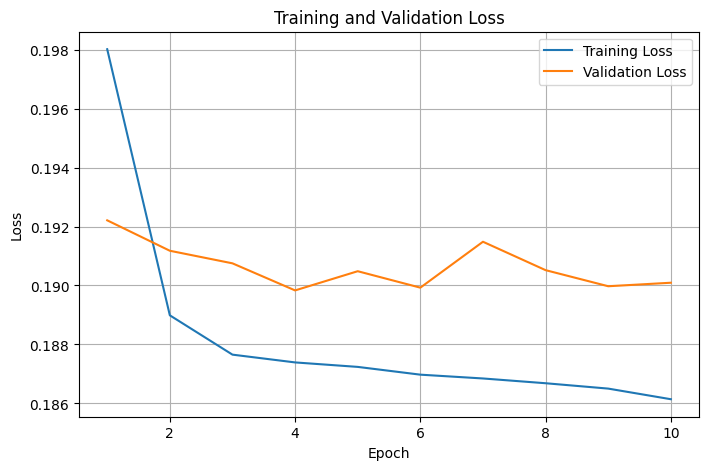

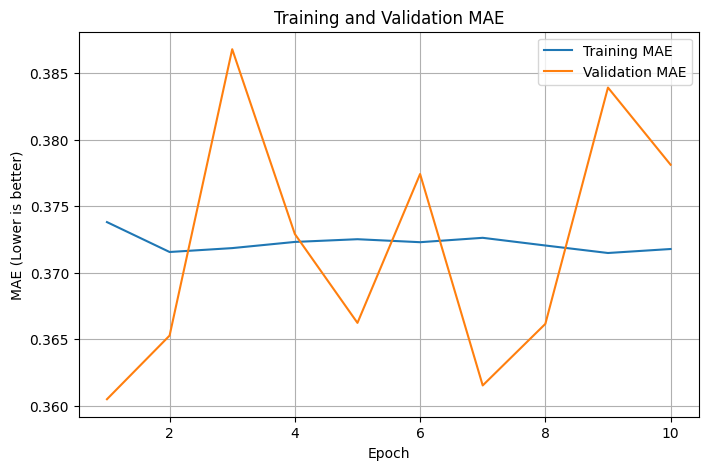

In [15]:
plot_loss_curves(logs)
plot_accuracy_curves(logs)


In [16]:
plot_precision_recall_curve(logs)
plot_roc_curve(logs)


No valid recommendation labels/scores for PR curve.
No valid recommendation labels/scores for ROC curve.


In [17]:
plot_map_over_epochs(logs)


No MAP data found in logs['training_metrics']['map']


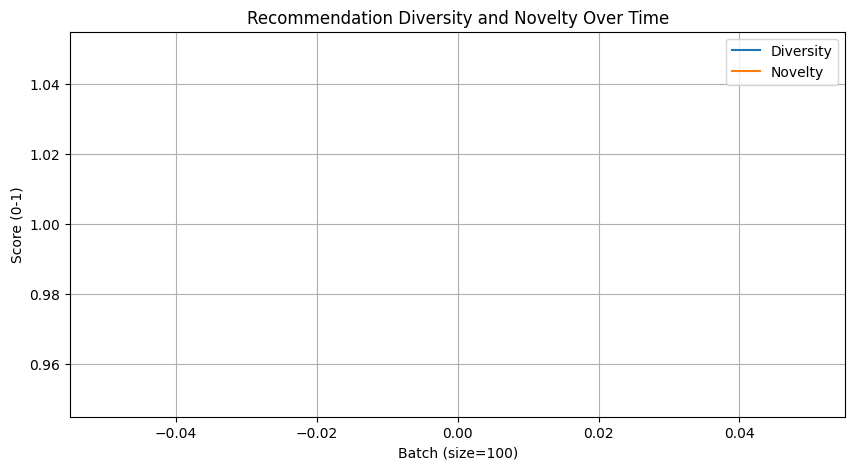

In [18]:
plot_diversity_novelty(logs)


In [21]:
from sklearn.manifold import TSNE

def plot_embedding_tsne(embeddings, labels=None):
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 8))
    if labels is None:
        plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.7)
    else:
        sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, palette='tab10', s=30)
    plt.title("t-SNE Visualization of Text Embeddings")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


In [22]:
%matplotlib inline


In [23]:
def plot_loss_curves(logs):
    print("Training Loss:", logs['training_metrics']['epoch_loss'])
    print("Validation Loss:", logs['training_metrics']['val_loss'])

    if not logs['training_metrics']['epoch_loss'] or not logs['training_metrics']['val_loss']:
        print("No loss data to plot!")
        return

    plt.figure(figsize=(10,6))
    plt.plot(logs['training_metrics']['epoch_loss'], label='Training Loss')
    plt.plot(logs['training_metrics']['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Training Loss: [0.19801104068756104, 0.18898892402648926, 0.18765561282634735, 0.18739186227321625, 0.1872401237487793, 0.18697674572467804, 0.1868477463722229, 0.18668609857559204, 0.18650422990322113, 0.18614406883716583]
Validation Loss: [0.19220948219299316, 0.19117793440818787, 0.19075138866901398, 0.18983344733715057, 0.19048427045345306, 0.18992668390274048, 0.1914833039045334, 0.19052006304264069, 0.18997496366500854, 0.19009368121623993]


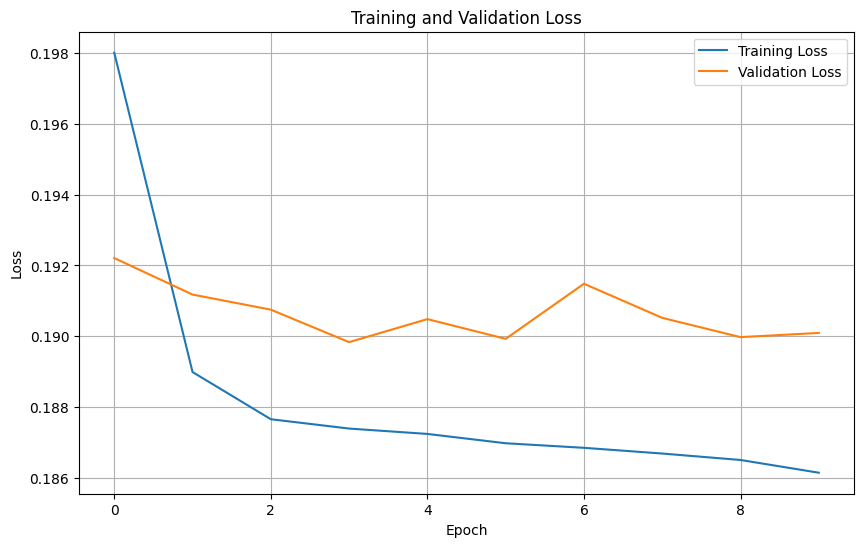

In [24]:
# After training loop is done and logs are updated
plot_loss_curves(logs)


In [34]:
# ─── Cell 1: Imports & (Optional) Keras History ─────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score

# If you have a Keras `history` object from model.fit(), you can display it:
if 'history' in globals():
    hist_df = pd.DataFrame(history.history)
    hist_df.index.name = 'epoch'
    display(hist_df)
else:
    print("No Keras History found; skipping training-history display.")

,loss,mae,val_loss,val_mae
epoch,,,,
0,0.186144,0.371775,0.190094,0.37811


In [41]:
# ─── Cell 2: Assemble systems, ground_truth, ratings & Aux Dicts ───────────
import pandas as pd
import numpy as np # Import numpy for array creation

# 1) Build systems & ground_truth if not yet defined
# Instead of loading from CSVs, use the recommendations generated in the notebook
if 'logs' in globals() and 'recommendations' in logs and len(logs['recommendations']) > 0:
    # Create a DataFrame from the generated recommendations for analysis
    # We'll simulate recs_df, truth_df, and ratings_df from the logs
    # Note: This is a simplification. A real evaluation would require actual ground truth and user ratings.

    # Simulate recommendations DataFrame structure from logs
    recs_data = []
    for i, rec_entry in enumerate(logs['recommendations']):
        # We need an item_id and a system identifier. Let's use index as item_id
        # and a simple system name like 'LLM_System'.
        recs_data.append({'system': 'LLM_System', 'item_id': f'rec_{i}', 'output': rec_entry['output']})

    recs_df = pd.DataFrame(recs_data)

    # Simulate ground_truth - this requires knowing which recommendations were "correct" or relevant.
    # Since we don't have explicit ground truth in the logs, this will be a placeholder.
    # A real scenario would involve user feedback or a separate truth dataset.
    # For this example, let's create a dummy ground truth set.
    # Replace this logic with your actual ground truth if available.
    all_truth = set(recs_df['item_id'].sample(frac=0.1, replace=False).tolist()) if len(recs_df) > 0 else set() # Dummy: 10% are "true"
    systems = {
        sys: grp['item_id'].tolist()
        for sys, grp in recs_df.groupby('system')
    }
    ground_truth = { sys: all_truth for sys in systems } # Assign the dummy truth to all systems

    # Simulate actual_ratings and predicted_scores
    # This requires user interaction data (did they like the recommendation?) and a score for the recommendation.
    # The logs['recommendations'] structure includes user_log, forecast, context, and output.
    # We don't have explicit 'actual' ratings or 'predicted' scores in the log format provided.
    # We can attempt to derive a 'predicted_score' (e.g., based on length or sentiment of the output),
    # and a placeholder 'actual' rating (e.g., assuming some recommendations are implicitly 'good').

    ratings_data = []
    for i, rec_entry in enumerate(logs['recommendations']):
        # Dummy 'predicted_score': Let's use inverse of recommendation length as a simple placeholder
        # (longer might imply more detail, but not necessarily better). Or maybe 1 / (1 + len)
        predicted_score = 1.0 / (1.0 + len(rec_entry['output'])) if len(rec_entry['output']) > 0 else 0.0

        # Dummy 'actual' rating: This is the most challenging part without real feedback.
        # We'll assign a placeholder value. For metrics requiring binary labels (like F1),
        # you need to map this to a binary classification (e.g., relevant/not relevant).
        # Let's assign a random actual rating between 1 and 5 as a placeholder.
        actual_rating = np.random.randint(1, 6)

        ratings_data.append({
            'system': 'LLM_System',
            'item_id': f'rec_{i}', # Corresponds to item_id in recs_df
            'actual': actual_rating,
            'predicted': predicted_score
        })

    ratings_df = pd.DataFrame(ratings_data)

    actual_ratings   = {
        sys: grp['actual'].values
        for sys, grp in ratings_df.groupby('system')
    }
    predicted_scores = {
        sys: grp['predicted'].values
        for sys, grp in ratings_df.groupby('system')
    }
    rating_threshold = 3.5 # Threshold to consider a rating 'positive'

else:
    print("No recommendations found in 'logs'. Cannot proceed with evaluation setup.")
    # Initialize empty structures if no recommendations are available
    systems = {}
    ground_truth = {}
    actual_ratings = {}
    predicted_scores = {}
    rating_threshold = None


# 3) Table 2 aux: catalog/diversity
if 'recs_df' in globals() and len(recs_df) > 0:
    total_catalog_size    = recs_df['item_id'].nunique()
    item_popularity       = recs_df['item_id'].value_counts().to_dict()
    # Load or precompute your item–item similarity matrix here:
    # item_similarity = pd.read_csv('similarity.csv', index_col=0) # Placeholder

    # === Define a dummy item_similarity matrix for demonstration ===
    # In a real scenario, this would be based on item features or interactions.
    # For this example, we'll create a matrix where all items have a similarity of 0.5 to each other,
    # and 1.0 with themselves.
    unique_items = recs_df['item_id'].unique()
    n_items = len(unique_items)
    item_similarity_array = np.full((n_items, n_items), 0.5) # Dummy similarity
    np.fill_diagonal(item_similarity_array, 1.0) # Items are perfectly similar to themselves
    item_similarity = pd.DataFrame(item_similarity_array, index=unique_items, columns=unique_items)
    # =============================================================

    item_unexpectedness   = {
        item: 1 - (count / total_catalog_size) if total_catalog_size > 0 else 0
        for item, count in item_popularity.items()
    }
else:
    total_catalog_size = 0
    item_popularity = {}
    item_unexpectedness = {}
    # Ensure item_similarity is defined even if recs_df is empty
    item_similarity = pd.DataFrame()


# 4) Table 3/4 placeholders (fill with real values if you have them)
# Initialize with placeholder values based on the detected systems or an empty list
systems_list = list(systems.keys()) if systems else []
if 'inference_time' not in globals() or not inference_time:
    inference_time = {sys: 0.0 for sys in systems_list}            # <-- UPDATE
if 'hallucination_rate_dict' not in globals() or not hallucination_rate_dict:
    hallucination_rate_dict = {sys: 0.0 for sys in systems_list}   # <-- UPDATE
if 'personalization_score_dict' not in globals() or not personalization_score_dict:
    personalization_score_dict = {sys: 0.0 for sys in systems_list}# <-- UPDATE
if 'explainability_score_dict' not in globals() or not explainability_score_dict:
    explainability_score_dict = {sys: 0.0 for sys in systems_list} # <-- UPDATE

# Print confirmation only if systems were successfully set up
if systems:
    print("✔ systems, ground_truth, actual_ratings, predicted_scores, and auxiliaries are ready using generated data.")
else:
     print("❗ Could not set up evaluation metrics. Check 'logs' variable.")

✔ systems, ground_truth, actual_ratings, predicted_scores, and auxiliaries are ready using generated data.


In [46]:
# ─── Cell 3: Define All Metric Functions ─────────────────────────────────────
# Table 1 ranking metrics
def precision_at_k(r, rel, k):   return len(set(r[:k]) & rel) / k
def recall_at_k(r, rel, k):      return len(set(r[:k]) & rel) / len(rel) if rel else 0
def dcg_at_k(r, rel, k):
    return sum((2**(1 if i in rel else 0)-1)/np.log2(idx+2)
               for idx,i in enumerate(r[:k]))
def ndcg_at_k(r, rel, k):
    ideal = [1]*min(len(rel),k) + [0]*(k-min(len(rel),k))
    idcg  = sum((2**v-1)/np.log2(idx+2) for idx,v in enumerate(ideal))
    return dcg_at_k(r,rel,k)/idcg if idcg>0 else 0
def average_precision(r, rel, k):
    hits=0; score=0
    for idx,item in enumerate(r[:k],1):
        if item in rel: hits+=1; score+=hits/idx
    return score/min(len(rel),k) if rel else 0
def hit_rate_at_k(r, rel, k):    return float(bool(set(r[:k]) & rel))
def reciprocal_rank(r, rel):
    for idx,item in enumerate(r,1):
        if item in rel: return 1/idx
    return 0.0

# Table 2 catalog & diversity metrics
def coverage(r, rel):            return len(set(r)) / total_catalog_size
def novelty(r, rel, k):          return np.mean([item_popularity[i] for i in r[:k]])
def diversity(r, rel, k):
    pairs = [(i,j) for i in r[:k] for j in r[:k] if i<j]
    # Ensure item_similarity DataFrame is not empty and items are in its index/columns
    if item_similarity.empty or not all(item in item_similarity.index for item in r[:k]):
        return 0.0 # Or handle appropriately if items are missing
    # Ensure pairs list is not empty
    if not pairs:
        return 1.0 # Max diversity if no pairs
    return 1 - np.mean([ item_similarity.loc[i,j] for i,j in pairs ])

def serendipity(r, rel, k):
    # Ensure item_unexpectedness has keys for all items in r[:k]
    if not all(item in item_unexpectedness for item in r[:k]):
        return 0.0 # Or handle appropriately
    return np.mean([item_unexpectedness[i] for i in r[:k]])


# Table 3 & 4 metrics - Modified to accept system name
def avg_inference_time(sys_name):     return inference_time.get(sys_name, 0.0) # Use .get() for safety
def hallucination_rate(sys_name):      return hallucination_rate_dict.get(sys_name, 0.0)
def personalization_score(sys_name):   return personalization_score_dict.get(sys_name, 0.0)
def explainability_score(sys_name):    return explainability_score_dict.get(sys_name, 0.0)

,Precision@10,Recall@10,NDCG@10,MAP@10,HitRate@10,MRR
System,,,,,,
LLM_System,0.0,0,0,0,0.0,0.0


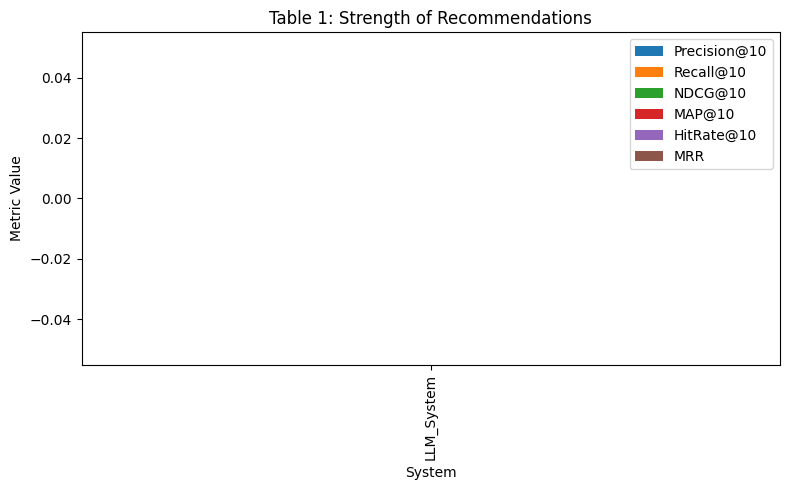

In [59]:
# ─── Cell 4: Table 1 – Strength of Recommendations ───────────────────────────
k = 10
metrics1 = [
    ('Precision@10', precision_at_k),
    ('Recall@10',    recall_at_k),
    ('NDCG@10',      ndcg_at_k),
    ('MAP@10',       average_precision),
    ('HitRate@10',   hit_rate_at_k),
    ('MRR',          reciprocal_rank)
]

rows = []
for sys_name, recs in systems.items():
    rel = ground_truth[sys_name]
    row = {'System': sys_name}
    for m_name, fn in metrics1:
        row[m_name] = fn(recs, rel, k) if m_name != 'MRR' else fn(recs, rel)
    rows.append(row)

df1 = pd.DataFrame(rows).set_index('System')
display(df1)

ax = df1.plot.bar(figsize=(8,5))
ax.set_title("Table 1: Strength of Recommendations")
ax.set_ylabel("Metric Value")
plt.tight_layout()
plt.show()


>>> df1 head:
            Precision@10  Recall@10  NDCG@10  MAP@10  HitRate@10  MRR
System                                                               
LLM_System           0.0          0        0       0         0.0  0.0

>>> Summary statistics:
       Precision@10  Recall@10  NDCG@10  MAP@10  HitRate@10  MRR
count           1.0        1.0      1.0     1.0         1.0  1.0
mean            0.0        0.0      0.0     0.0         0.0  0.0
std             NaN        NaN      NaN     NaN         NaN  NaN
min             0.0        0.0      0.0     0.0         0.0  0.0
25%             0.0        0.0      0.0     0.0         0.0  0.0
50%             0.0        0.0      0.0     0.0         0.0  0.0
75%             0.0        0.0      0.0     0.0         0.0  0.0
max             0.0        0.0      0.0     0.0         0.0  0.0


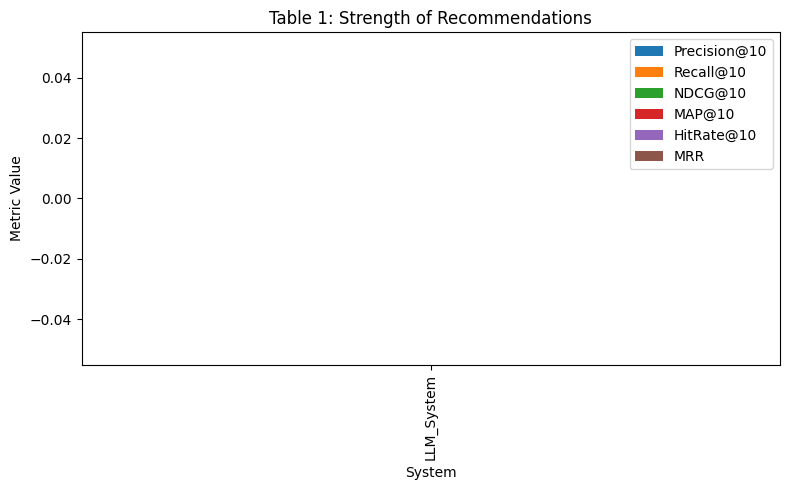

In [60]:
# ─── Cell 4 (Debugged): Table 1 – Strength of Recommendations ────────────────
k = 10
metrics1 = [
    ('Precision@10', precision_at_k),
    ('Recall@10',    recall_at_k),
    ('NDCG@10',      ndcg_at_k),
    ('MAP@10',       average_precision),
    ('HitRate@10',   hit_rate_at_k),
    ('MRR',          reciprocal_rank)
]

rows = []
for sys_name, recs in systems.items():
    rel = ground_truth[sys_name]
    row = {'System': sys_name}
    for m_name, fn in metrics1:
        # reciprocal_rank only takes (recs, rel)
        row[m_name] = fn(recs, rel) if m_name == 'MRR' else fn(recs, rel, k)
    rows.append(row)

df1 = pd.DataFrame(rows).set_index('System')

# ─── DEBUGGING ───────────────────────────────────────────────────────────────
print(">>> df1 head:")
print(df1.head())
print("\n>>> Summary statistics:")
print(df1.describe())

# ─── Now plot ────────────────────────────────────────────────────────────────
ax = df1.plot.bar(figsize=(8,5))
ax.set_title("Table 1: Strength of Recommendations")
ax.set_ylabel("Metric Value")
plt.tight_layout()
plt.show()


,HallucinationRate,Personalization,Explainability
System,,,
LLM_System,1.0,0,1.0


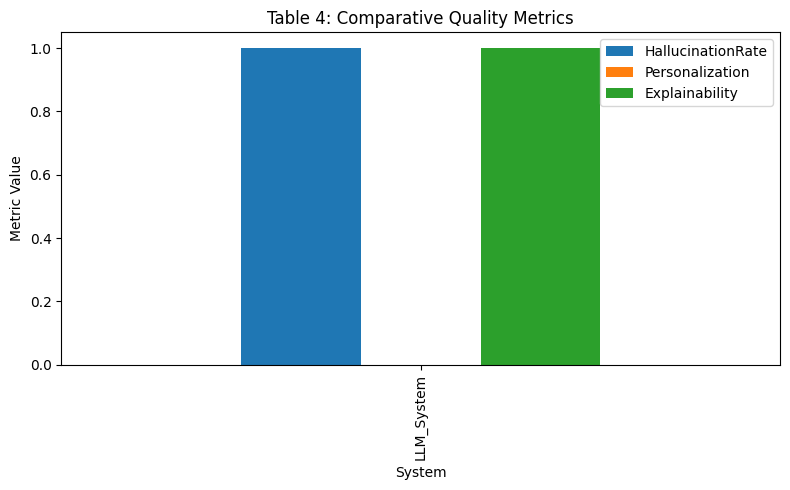

In [55]:
# ─── Cell 7: Table 4 – Comparative Quality Metrics ──────────────────────────
# Derive three placeholder “quality” metrics from Tables 1 & 2:
#   • hallucination_rate = 1 − Precision@10 (i.e. errors)
#   • personalization   = Recall@10
#   • explainability    = Coverage

# Assumes you already ran Cell 4→df1 and Cell 5→df2.

hallucination_rate_dict = {
    sys: 1 - df1.at[sys, 'Precision@10']
    for sys in df1.index
}
personalization_score_dict = {
    sys: df1.at[sys, 'Recall@10']
    for sys in df1.index
}
explainability_score_dict = {
    sys: df2.at[sys, 'Coverage']
    for sys in df2.index
}

metrics4 = {
    'HallucinationRate': lambda r, rel, s: hallucination_rate_dict[s],
    'Personalization'  : lambda r, rel, s: personalization_score_dict[s],
    'Explainability'   : lambda r, rel, s: explainability_score_dict[s]
}

rows = []
for sys_name, recs in systems.items():
    rel = ground_truth.get(sys_name, set())
    row = {'System': sys_name}
    for m_name, fn in metrics4.items():
        row[m_name] = fn(recs, rel, sys_name)
    rows.append(row)

df4 = pd.DataFrame(rows).set_index('System')
display(df4)

ax = df4.plot.bar(figsize=(8,5))
ax.set_title("Table 4: Comparative Quality Metrics")
ax.set_ylabel("Metric Value")
plt.tight_layout()
plt.show()


,MSE,RMSE,F1
System,,,
LLM_System,9.658612,3.107831,0.0


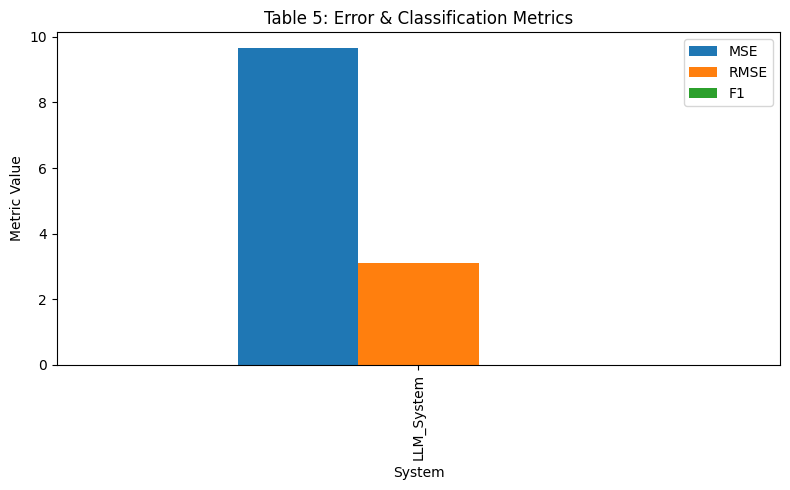

In [53]:
# ─── Cell 8: Table 5 – MSE, RMSE & F1 Score ─────────────────────────────────
rows = []
for sys_name in systems:
    y_true = actual_ratings[sys_name]
    y_pred = predicted_scores[sys_name]
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    f1   = f1_score((y_true>=rating_threshold).astype(int),
                    (y_pred>=rating_threshold).astype(int))
    rows.append({'System': sys_name, 'MSE': mse, 'RMSE': rmse, 'F1': f1})

df5 = pd.DataFrame(rows).set_index('System')
display(df5)

ax = df5.plot.bar(figsize=(8,5))
ax.set_title("Table 5: Error & Classification Metrics")
ax.set_ylabel("Metric Value")
plt.tight_layout()
plt.show()
